In [10]:
import numpy as np
from labtools import time_freq_scan as tfs
import labtools as lt
from matplotlib import pyplot as plt
import os
from scipy.signal import find_peaks

from labtools import scanner
from scipy.optimize import curve_fit
from numpy import array
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [11]:
folder = "/home/bbuusshh/Desktop/git_lab/data/etaDIP/17"

In [12]:
dump_dip = "eta_betterBtoN_molecule3_0.dump"

In [13]:
data = np.fromfile(os.path.join(folder, dump_dip),count=int(-1), dtype=lt.DUMP_TYPE)

In [14]:
data = lt.assign_trigs_to_clicks(data, pix_trigs=[6,7], return_trig=True)
trig = lt.get_trig_len(data)
data = data[data['channel']!= 5]

In [15]:
len(data[data['channel']==7])

2165

In [16]:
len(data[data['channel']==6])

483346

In [17]:
line_trig = 7
pix_trig = 6

In [18]:
d_0 = np.split(data, np.where(data['channel'] == line_trig)[0])
d_lines = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0]), d_0)))

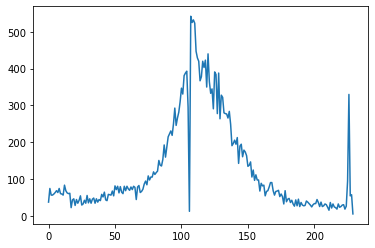

In [19]:
line = d_lines[1]

peak_distance_param=0.25
peak_height_param=0.1
spectr = np.array([len(px) for px in line])

plt.plot(spectr)

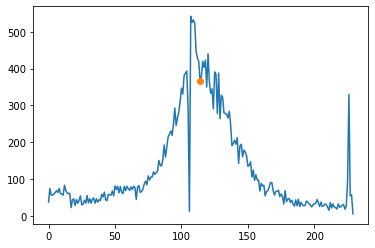

In [20]:
peak_distance_param=0.25
peak_height_param=0.1

peaks, _ = find_peaks(spectr/np.max(spectr), height=peak_height_param, distance=len(spectr)*peak_distance_param)


pk = peaks[spectr[peaks].argmax()]

fr = np.arange(len(spectr))

popt, pcov =curve_fit(scanner.lorentz, fr, spectr, p0=[100,10,pk,100])
perr = np.sqrt(np.diag(pcov)[np.diag(pcov)>0])
tot_err = perr.sum()
pk = int(popt[2])


plt.plot(fr,spectr)
plt.plot(fr[pk], spectr[pk], 'o')

In [21]:
def get_most_often_linelen(d_lines, clusters=2):
    pxls  = np.array([len(i) for i in d_lines])
    whitened = whiten(pxls)
    centroids, distortion = kmeans(whitened,clusters)
    clx,_ = vq(whitened,centroids)
    clust = np.argmax([len(clx[clx==c]) for c in np.unique(clx)])
    lines_pxs = np.mean(pxls[clx == clust]).astype(int)
    return lines_pxs, pxls, clx,clust, distortion

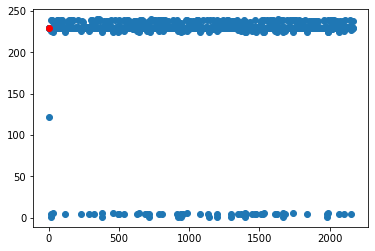

In [22]:
lines_pxs, pxls, clx,clust, distortion = get_most_often_linelen(d_lines, clusters=4)
plt.plot(pxls, 'o')
plt.plot(lines_pxs, 'ro')

In [23]:
pxls  = np.array([len(i) for i in d_lines[clx==clust]])
pxls

array([122, 230, 230, ..., 229, 229, 229])

In [24]:
d_lines = np.array(d_lines)[clx==clust]

In [25]:
px_min = min(np.array([len(i) for i in d_lines]))
px_min

122

In [26]:
px_max = max(np.array([len(i) for i in d_lines]))
px_max

233

We constrain line pixel len by line_x[0:px_min-1], as the scan return tim eis for some mystical reason variable

## Align!

In [27]:
incRand = np.random.random_integers(0, len(d_lines) - 1,size=10)

In [30]:
incRand = np.random.random_integers(0, len(d_lines) - 1,size=20)
t = [int(px[0]['time']) - int(d_lines[0][0][0]['time']) for px in d_lines[0]]
center = (int(d_lines[0][-1][0]['time']) - int(d_lines[0][0][0]['time']))/2
center

peak_distance_param=0.25
peak_height_param=0.1

shifts = []
for line in np.array(d_lines):
    line = line[:px_min]
    t = [int(px[0]['time']) - int(line[0][0]['time']) for px in line]
    spectr = np.array([len(px) for px in line])
    peaks, _ = find_peaks(spectr/np.max(spectr), height=peak_height_param, distance=len(spectr)*peak_distance_param)
    if len(peaks)*len(spectr) == 0:
        continue
    pk = peaks[spectr[peaks].argmax()]
    try:
        popt, pcov =curve_fit(scanner.lorentz, fr, spectr, p0=[100,10,pk,100])
        perr = np.sqrt(np.diag(pcov)[np.diag(pcov)>0])
        tot_err = perr.sum()
        pk = int(popt[2])
    except:
        continue
        print("skip")
    sh = t[pk]
    #plt.plot(fr,spectr)
    #plt.plot(fr[pk], spectr[pk], 'o')
    shift = sh - center
    shifts.append(shift)
    #print(sh)
    line[0]['time'] = line[0]['time'] + shift
    #line = [px['time'] + shift for px in line]


IndexError: list index out of range

In [ ]:
data2 = np.concatenate(np.concatenate(d_lines))
data2 = data2[np.argsort(data2['time'])]

d_0 = np.split(data2, np.where(data2['channel'] == line_trig)[0])
d_lines = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0]), d_0)))

lines_pxs, pxls, clx,clust, distortion = get_most_often_linelen(d_lines, clusters=4)
d_lines = np.array(d_lines)[clx==clust]
px_min = min(np.array([len(i) for i in d_lines]))
px_min

plt.plot(pxls, 'o')
plt.plot(lines_pxs, 'ro')

In [ ]:
import pickle

In [ ]:
#f = open("d_lines_pulse_seq_dip_1.pickle", "wb")
#pickle.dump(d_lines, f)

In [ ]:
binNum = 1000

In [ ]:
img = np.zeros((px_min, binNum))
for line_x in d_lines[1:]:
    line = np.zeros(binNum)
    for px in line_x[0:px_min-1]:
        y,x = np.histogram(px['time_from_trig'], bins=binNum, range=(10, trig))
        line = np.vstack((line, y))
    img = np.dstack((img, line))

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(img[70:390,600:660,:].sum(axis=2).T, aspect='auto')

In [ ]:
plt.imshow(img[180:280,:,:].sum(axis=2).T, aspect='auto')

In [ ]:
hista = img[:,:,:].sum(axis=2).T.sum(axis=1)
pks, _= find_peaks(hista, distance=len(hista)/20)

In [ ]:
img[:,:,:].sum(axis=2).T.sum(axis=1)

In [ ]:
plt.plot(np.arange(len(hista)), hista)
plt.plot(np.arange(len(hista))[pks], hista[pks], 'o')

In [ ]:
pks

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

In [ ]:
from matplotlib import cm

In [ ]:
fig, axs = plt.subplots(len(pks), figsize=(8, 100))
for idx, i in enumerate(pks):
    #plt.subplot(idx + 1,1,1)
    axs[idx].imshow(img[100:360,i-20:i+60,:].sum(axis=2).T, aspect='auto', cmap=cm.cividis)
    
fig.tight_layout()
plt.savefig('dips_cvidis.pdf')

In [ ]:
#f = open("img_pulse_seq_dip_1.pickle", "wb")
#pickle.dump(img, f)

In [ ]:
plt.plot(img[:,2880:3000,:1500].sum(axis=2).T.sum(axis=1))

In [ ]:
plt.plot(img.sum(axis=2).T.sum(axis=1))